In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
/device:GPU:0
Num GPUs Available:  1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U keras-tuner
import seaborn as sns
import numpy as np
import IPython
import kerastuner as kt
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, Conv2D, MaxPool2D, BatchNormalization,Dense,GlobalAveragePooling2D,Flatten
from tensorflow.keras import Model,layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from kerastuner.engine.hyperparameters import HyperParameters


In [4]:
#Reading data from zipfile
local_zip = '/content/drive/My Drive/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
base_dir = '/tmp/chest_xray'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
val_dir = os.path.join(base_dir,'val')
train_normal_dir = os.path.join(train_dir,'NORMAL')
train_affected_dir = os.path.join(train_dir,'PNEUMONIA')

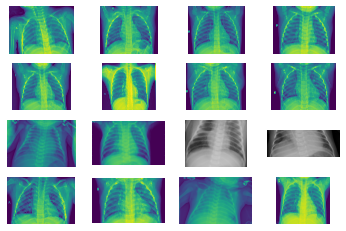

In [7]:
#Visualising the data
train_normal_fnames = os.listdir(train_normal_dir)
train_affected_fnames = os.listdir(train_affected_dir)
nrows = 4
ncols = 4
pic_index = 0
fig = plt.gcf()
pic_index+=8
next_normal_pic = [os.path.join(train_normal_dir,fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
next_affected_pic = [os.path.join(train_affected_dir,fname) for fname in train_affected_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_normal_pic+next_affected_pic):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
# Data augmentation using 'ImageDataGenerator'
IMG_SIZE  = 200

train_data_gen = ImageDataGenerator(rescale = 1/255, rotation_range = 30, 
                               zoom_range = 0.2, width_shift_range = 0.2, 
                               height_shift_range = 0.2, horizontal_flip = True)
train_data = train_data_gen.flow_from_directory(train_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

data_gen = ImageDataGenerator(rescale = 1/255)
val_data = data_gen.flow_from_directory(val_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

test_data = data_gen.flow_from_directory(test_dir,target_size = (IMG_SIZE,IMG_SIZE), class_mode = 'binary')

Found 5208 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
COUNT_NORMAL = len(train_normal_fnames)
COUNT_AFFECTED = len(train_affected_fnames)
TRAIN_IMG_COUNT = COUNT_AFFECTED + COUNT_NORMAL
initial_bias = np.log([COUNT_AFFECTED/COUNT_NORMAL])

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output  

--2020-10-27 10:31:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   334MB/s    in 0.3s    

2020-10-27 10:31:06 (334 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 10, 10, 768)


In [11]:
# Correcting the data imbalance using class weights
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_AFFECTED)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [12]:
def model_builder(hp):
  output_bias = tf.keras.initializers.Constant(initial_bias)
  l1_regularizer = hp.Choice('l1',values = [1e-4,1e-5,1e-6,1e-7]) 
  l2_regularizer = hp.Choice('l2',values = [1e-4,1e-5,1e-6,1e-7])
  dropout_prob = hp.Choice('prob',values = [0.2,0.25,0.3,0.35,0.4])
  hp_units = hp.Int('units',min_value = 64, max_value = 128, step = 16)
  x = Conv2D(256,(3,3),activation = 'relu',name = 'conv1',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(last_output)
  x = Conv2D(128,(3,3),activation='relu', name = 'conv2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
  x = Conv2D(hp_units,(3,3),activation='relu', name = 'conv3',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
  x = Conv2D(1,(1,1),activation = 'relu',name = 'conv4',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
  x = BatchNormalization(name = 'Batch_1')(x) 
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = BatchNormalization(name = 'Batch_2')(x) 
  x = Dense(128,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
  x = Dropout(dropout_prob)(x)
  x = Dense(hp_units,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_regularizer, l2=l2_regularizer))(x)
  x = Dropout(dropout_prob)(x)
  x = Dense(1,activation = 'sigmoid')(x)
  model = Model(pre_trained_model.input,x)
  model.compile(optimizer = RMSprop(lr = 0.01), loss = 'binary_crossentropy',metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
  return model

In [13]:
#Performing hyperparameter tuning for better results 
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 7,
                     factor = 3,
                     directory = 'hyperparameters',
                     project_name = 'Chest_X_RAY')
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
tuner.search(train_data, epochs = 5, validation_data = (val_data), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]                       

INFO:tensorflow:Oracle triggered exit


In [14]:
#Training the model using earlystopping and saving the weights of the best training score result
model = tuner.hypermodel.build(best_hps)
epochs_to_wait_for_improve = 20
n_epochs = 100
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('BINARY'+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_data,validation_data=val_data,class_weight= class_weight,
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])


Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 0.4969 - precision: 0.9672 - recall: 0.8772 - accuracy: 0.8867
Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to BINARY.h5
163/163 [==============================] - 89s 544ms/step - loss: 0.4969 - precision: 0.9672 - recall: 0.8772 - accuracy: 0.8867 - val_loss: 0.6778 - val_precision: 1.0000 - val_recall: 0.6250 - val_accuracy: 0.7500
Epoch 2/100
163/163 [==============================] - ETA: 0s - loss: 0.3688 - precision: 0.9774 - recall: 0.9170 - accuracy: 0.9226
Epoch 00002: val_accuracy improved from 0.75000 to 0.95833, saving model to BINARY.h5
163/163 [==============================] - 88s 537ms/step - loss: 0.3688 - precision: 0.9774 - recall: 0.9170 - accuracy: 0.9226 - val_loss: 0.2863 - val_precision: 0.9412 - val_recall: 1.0000 - val_accuracy: 0.9583
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 0.3550 - precision: 0.9754 - recall: 0.9216 - accuracy: 0.92

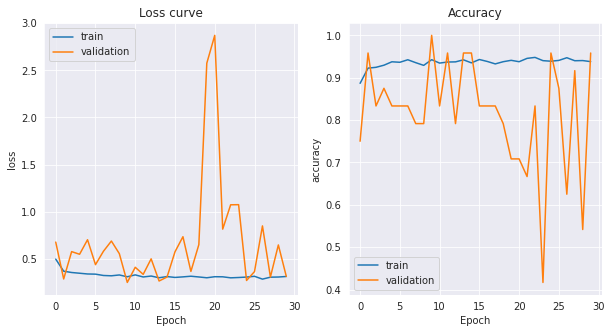

In [15]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()